# MW - LMC time-evolv Dynamical Friction optimizer

Context: The LMC is the most massive satellite of the Milky Way,
and it perturbs the motion of stars in the outer regions of the Galaxy due to two effects:
(1) stars that pass in its vicinity are deflected and form an overdensity behind the LMC
on its trajectory, which in turn is responsible for dynamical friction (local pertubations);
(2) the Milky Way itself is not fixed in space, but moves in response to the gravitational
pull of the LMC. Moreover, stars at large distances from the MW center experience different
amounts of perturbation from the LMC, and therefore are systematically shifted and
accelerated w.r.t. the Galactic center (global perturbations).

This script illustrates both effects in a simplified setup, where the relative motion
of the Milky Way and the LMC is approximated as if both galaxies had rigid (moving but
non-deforming) potentials, and then the orbits of test particles in the Milky Way halo
are computed in the resulting time-dependent potential of the MW-LMC system.


Moreover, it performs optmizations to fit the Coulumb Logarithm parameters to match the best case trajectory for any verison of the MW-LMC potentials  

In [1]:
import sys, os, numpy as np 
import matplotlib, matplotlib.pyplot as plt
import agama
agama.setUnits(length=1, velocity=1, mass=1)  # work in units of 1 kpc, 1 km/s, 1 Msun)

# robust import (supports older Pythons with backport)
try:
    from importlib import resources
except ImportError:
    import importlib_resources as resources

from pathlib import Path
import numpy as np
from configparser import ConfigParser

# base data directory inside package
data_dir = resources.files("nbody_streams").joinpath("data")
BASE_POT_PATH = 'potentials/MW_LMC_evolv/'

# Read or generate MW_LMC_evolv for stellar streams:

In [2]:
# work in units of 1 kpc, 1 km/s, 1 Msun)# MW-LMC best fit streams Potential
# let's use McMillan+2017 version from Shipp+2021:  
# Define file paths
potMW_path = os.path.join(data_dir, BASE_POT_PATH, 'McMillan17_streams.ini')
potLMC_path = os.path.join(data_dir, BASE_POT_PATH, 'LMC_vasiliev21.ini')
accMW_path = os.path.join(data_dir, BASE_POT_PATH, 'accMW_McM17streams')
trajLMC_path = os.path.join(data_dir, BASE_POT_PATH, 'trajLMC_McM17streams')

def all_files_exist(file_list):
    import os
    for file_path in file_list:
        if not os.path.exists(file_path):
            return False
    return True

# Check if saved files exist
files_exist = all_files_exist([
    potMW_path, potLMC_path, accMW_path, trajLMC_path
])

if files_exist:
    try:
        print('Loading precomputed MW-LMC potential files...')

        # # load in the MW potenital from Shipp+2021, along with reflex of the MW due to the LMC
        potMW = agama.Potential(file=potMW_path)
        accMW = np.loadtxt(accMW_path)

        # # load in the LMC potential from Vasiliev+2021, along with the LMC trajectory
        trajLMC = np.loadtxt(trajLMC_path)
        potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
        potLMC  = agama.Potential(file=potLMC_path)
        potLMCm = agama.Potential(potential=potLMC, center=trajLMC)

        # # combine to form a full MW-LMC potential in MW-centric non-inertial reference frame.
        potTotal= agama.Potential(potMW, potLMCm, potacc)
        print('Successfully loaded MW-LMC potential.')
        
    except Exception as e:
        print(f'Error loading files: {e}')
        print('Will recompute...')
        files_exist = False

if not files_exist:
    print('Computing the MW-LMC potential from scratch...')
    import scipy.integrate, scipy.ndimage, scipy.special
    # ============================================================
    # 1. SET UP POTENTIALS  (McMillan17 / Shipp+2021 flavour)
    # ============================================================
    paramThinDisk = dict(type='Disk', surfaceDensity=6.79343e+08,
                         scaleRadius=2.82344, scaleHeight=0.3)
    paramThickDisk = dict(type='Disk', surfaceDensity=2.31801e+08,
                          scaleRadius=2.95513, scaleHeight=0.9)
    paramH1GasDisk = dict(type='Disk', surfaceDensity=5.31319e+07,
                          scaleRadius=7, scaleHeight=-0.085, innerCutoffRadius=4)
    paramMolecularGasDisk = dict(type='Disk', surfaceDensity=2.17995e+09,
                                 scaleRadius=1.5, scaleHeight=-0.045, innerCutoffRadius=12)
    paramBulge = dict(type='Spheroid', densityNorm=1.04699e+11, axisRatioZ=0.5,
                      gamma=0, beta=1.8, scaleRadius=0.075, outerCutoffRadius=2.1)
    paramHalo = dict(type='Spheroid', densityNorm=1.57622e+07, axisRatioZ=1,
                     cutoffStrength=4, gamma=1, beta=3, scaleRadius=13.1445)
    
    densMWhalo = agama.Density(paramHalo)
    potMW = agama.Potential(paramBulge, paramHalo,
                            paramThinDisk, paramThickDisk,
                            paramH1GasDisk, paramMolecularGasDisk)
    
    # Create the LMC potential - a spherical truncated NFW profile with mass and radius
    # related by the equation below, which produces approximately the same enclosed mass
    # profile in the inner region, satisfying the observational constraints, as shown
    # in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
    massLMC   = 1.5e11
    radiusLMC = (massLMC / 1e11)**0.6 * 8.5
    potLMC    = agama.Potential(type='spheroid', mass=massLMC, scaleradius=radiusLMC,
                                outercutoffradius=radiusLMC * 10, gamma=1, beta=3)

    # heliocentric ICRS celestial coordinates and velocity of the LMC
    # (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
    # LMC current phase-space coordinates
    ra, dec, dist_lmc, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
    # transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
    # (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
    l, b, pml, pmb = agama.transformCelestialCoords(
        agama.fromICRStoGalactic, ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
    posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist_lmc, pml*4.74, pmb*4.74, vlos)
    
    # Velocity dispersion from the McMillan17 halo
    potMWsph = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
    gmHalo   = agama.GalaxyModel(potMWsph,
        agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))
    rgrid   = np.logspace(1, 3, 16)
    xyzgrid = np.column_stack([rgrid, rgrid*0, rgrid*0])
    sigmafnc = agama.Spline(rgrid,
        gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5)
    
    # Simulate (approximately!) the past trajectory of the MW+LMC system under mutual gravity.
    # Here, we integrate in time a 12-dimensional ODE system for positions & velocities of
    # both galaxies in the external inertial reference frame. The acceleration of each galaxy
    # is computed by taking the gradient of the rigid (non-deforming) potential of the other
    # galaxy at the location of the first galaxy's center, and then assuming that the entire
    # first galaxy experiences the same acceleration and continues to move as a rigid body.
    # The same procedure then is applied in reverse. Moreover, we add a dynamical friction
    # acceleration to the LMC, but not to the Milky Way; it is computed using the standard
    # Chandrasekhar's formula, but with a spatially-varying value of Coulomb logarithm,
    # which has been calibrated against full N-body simulations.
    # This simplified model is certainly not physically correct, e.g. manifestly violates
    # Newton's third law, but still captures the main features of the actual interaction.
    
    # ============================================================
    # 2. INTEGRATION MACHINERY
    # ============================================================
    Trewind = -10.0
    Tcurr   =  0.0
    Tstep   = 1./64
    tgrid   = np.linspace(Trewind, Tcurr, round((Tcurr - Trewind) / Tstep) + 1)
    ic      = np.hstack((np.zeros(6), posvelLMC))

    # ============================================================
    # Best fit Dynamical Friction from optimizers
    # ============================================================
    bmin_factor, power = 1.8715, 1.0548 # default values tuned to approx LMC trajectory 2.0, 0.5
    bminCouLog = radiusLMC * bmin_factor
        
    def difeq(vars, t):
        x0   = vars[0:3]
        v0   = vars[3:6]
        x1   = vars[6:9]
        v1   = vars[9:12]
        dx   = x1 - x0
        dv   = v1 - v0
        d    = np.sqrt(np.sum(dx**2))
        vmag = np.sqrt(np.sum(dv**2))
        f0   = potLMC.force(-dx)
        f1   = potMW.force(dx)
        rho  = potMW.density(dx)
        sig  = sigmafnc(d)
        couLog = max(0.0, np.log(d / bminCouLog)**power)
        X    = vmag / (sig * np.sqrt(2.0))
        drag = -(4 * np.pi * rho * dv / vmag *
                 (scipy.special.erf(X) - 2/np.sqrt(np.pi) * X * np.exp(-X*X)) *
                 massLMC * agama.G**2 / vmag**2 * couLog)
        return np.hstack((v0, f0, v1, f1 + drag))

    print(f'Solving the 12D ODE for MW-LMC system.')
    from time import perf_counter
    from datetime import timedelta
    t0=perf_counter()
    sol = scipy.integrate.odeint(difeq, ic, tgrid[::-1])[::-1]
    elapsed = str(timedelta(seconds=perf_counter()-t0))
    print(f'Solved the ODEs in {elapsed}.')

    # After obtaining the solution for trajectories of both galaxies,
    # we transform it into a more convenient form, namely, into the non-inertial
    # reference frame centered at the Milky Way center at all times.
    # In this frame, the total time-dependent gravitational potential consists of
    # three terms. First is the rigid potential of the Milky Way itself.
    # Because the latter moves on a curvilinear trajectory, we need to add
    # a corresponding spatially uniform acceleration field. Finally, the potential
    # of the LMC is also rigid but moves in space.

    # LMC trajectory in the MW-centric (non-inertial) reference frame
    # (7 columns: time, 3 position and 3 velocity components)
    trajLMC = np.column_stack([tgrid, sol[:,6:12] - sol[:,0:6]])
    # MW trajectory in the inertial frame
    trajMWx = agama.Spline(tgrid, sol[:,0], der=sol[:,3])
    trajMWy = agama.Spline(tgrid, sol[:,1], der=sol[:,4])
    trajMWz = agama.Spline(tgrid, sol[:,2], der=sol[:,5])
    
    # MW centre acceleration is minus the second derivative of its trajectory in the inertial frame
    accMW   = np.column_stack([tgrid, -trajMWx(tgrid, 2), -trajMWy(tgrid, 2), -trajMWz(tgrid, 2)])
    potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
    potLMCm = agama.Potential(potential=potLMC, center=trajLMC)
    
    # finally, the total time-dependent potential in the non-inertial MW-centric reference frame
    potTotal= agama.Potential(potMW, potLMCm, potacc)

    # Save results to disk
    try:
        # Create directory if it doesn't exist
        os.makedirs(BASE_POT_PATH, exist_ok=True)
        
        np.savetxt(accMW_path, accMW, 
                   header='Time[Gyr], a_x[km/s/Gyr], a_y[km/s/Gyr], a_z[km/s/Gyr]')
        np.savetxt(trajLMC_path, trajLMC, 
                   header='Time[Gyr], x[kpc], y[kpc], z[kpc], vx[km/s], vy[km/s], vz[km/s]')
        print(f'Successfully saved MW-LMC potential files to {BASE_POT_PATH}')
    except Exception as e:
        print(f'Warning: Could not save potential files: {e}')
        print('Potential has been computed but not saved to disk.')

Loading precomputed MW-LMC potential files...
Successfully loaded MW-LMC potential.


In [3]:
potTotal ## this is the time_evolv potential object that works

CompositePotential{ DiskAnsatz, DiskAnsatz, DiskAnsatz, DiskAnsatz, Multipole, Shifted Multipole, UniformAcceleration } (symmetry: None)

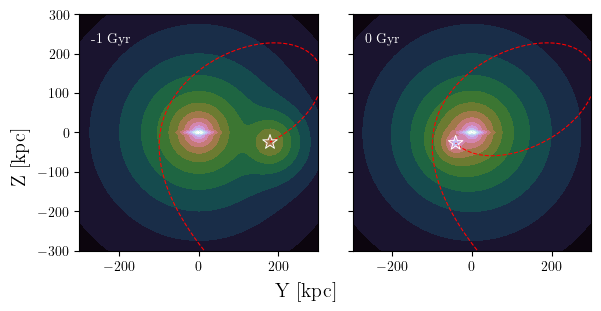

In [4]:
grid = np.linspace(-300, 300, 101)
xyz = np.column_stack(
    [np.zeros(len(grid)**2),
     np.repeat(grid, len(grid)),
     np.tile(grid, len(grid)),
    ]
)
den_1Gyrago = potTotal.density(xyz, t=-1).reshape(len(grid), len(grid)).T
den_0Gyrago = potTotal.density(xyz, t=-0.0001).reshape(len(grid), len(grid)).T

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True)

# Plotting loops/logic to keep code DRY (Don't Repeat Yourself)
times = [-1, 0]
densities = [den_1Gyrago, den_0Gyrago]
labels = ["-1 Gyr", "0 Gyr"]

for i, (t_val, den, lbl) in enumerate(zip(times, densities, labels)):
    # Contour plot
    im = ax[i].contourf(grid, grid, np.log10(den), levels=15, cmap='cubehelix')
    
    # Filter trajectory for the specific time
    mask = trajLMC[:, 0] <= t_val
    path = trajLMC[mask]
    
    if len(path) > 0:
        # 1. Red dashed line
        ax[i].plot(path[:, 2], path[:, 3], '--', c='r', lw=0.8)
        
        # 2. Unfilled star at the FINAL location
        # facecolors='none' makes it unfilled
        ax[i].scatter(path[-1, 2], path[-1, 3], marker='*', s=120, 
                      facecolors='none', edgecolors='white', linewidths=0.7, zorder=5)

    # 3. Annotations on top left
    ax[i].text(0.05, 0.92, lbl, transform=ax[i].transAxes, color='white', 
               fontsize=10, fontweight='bold', va='top')

# 4. Common Labels
fig.supxlabel('Y [kpc]')
fig.supylabel('Z [kpc]')

# Limits
ax[0].set_xlim(min(grid), max(grid))
ax[0].set_ylim(min(grid), max(grid))

plt.show()

# Approx MW-LMC ode that matches the LMC orbits roughly, based on N-body sims

The following code is from Eugene Vasiliev in an approximated MW-LMC system. The trajectories are matched with Nbody simulations

In [5]:
import scipy.integrate, scipy.ndimage, scipy.special

In [6]:
Trewind = -10.0  # initial time [Gyr] - the LMC orbit is computed back to that time
Tcurr   =  0.0  # current time
# heliocentric ICRS celestial coordinates and velocity of the LMC
# (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
# transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
# (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)

# Create a simple but realistic model of the Milky Way with a bulge, a single disk,
# and a spherical dark halo
paramBulge = dict(
    type              = 'Spheroid',
    mass              = 1.2e10,
    scaleRadius       = 0.2,
    outerCutoffRadius = 1.8,
    gamma             = 0.0,
    beta              = 1.8)
paramDisk  = dict(
    type='Disk',
    mass              = 5.0e10,
    scaleRadius       = 3.0,
    scaleHeight       = -0.4)
paramHalo  = dict(
    type              = 'Spheroid',
    densityNorm       = 1.35e7,
    scaleRadius       = 14,
    outerCutoffRadius = 300,
    cutoffStrength    = 4,
    gamma             = 1,
    beta              = 3)
densMWhalo = agama.Density(paramHalo)
potMW      = agama.Potential(paramBulge, paramDisk, paramHalo)

# create a sphericalized MW potential and a corresponding isotropic halo distribution function
potMWsph   = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
gmHalo     = agama.GalaxyModel(potMWsph,
    agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))

# compute the velocity dispersion in the MW halo needed for the dynamical friction
rgrid      = np.logspace(1, 3, 16)
xyzgrid    = np.column_stack([rgrid, rgrid*0, rgrid*0])
sigmafnc   = agama.Spline(rgrid, gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5)

# Create the LMC potential - a spherical truncated NFW profile with mass and radius
# related by the equation below, which produces approximately the same enclosed mass
# profile in the inner region, satisfying the observational constraints, as shown
# in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
massLMC    = 1.5e11
radiusLMC  = (massLMC/1e11)**0.6 * 8.5
bminCouLog = radiusLMC * 2.0   # minimum impact parameter in the Coulomb logarithm
potLMC     = agama.Potential(
    type              = 'spheroid',
    mass              = massLMC,
    scaleradius       = radiusLMC,
    outercutoffradius = radiusLMC*10,
    gamma             = 1,
    beta              = 3)

######## PART ONE ########
# Simulate (approximately!) the past trajectory of the MW+LMC system under mutual gravity.
# Here, we integrate in time a 12-dimensional ODE system for positions & velocities of
# both galaxies in the external inertial reference frame. The acceleration of each galaxy
# is computed by taking the gradient of the rigid (non-deforming) potential of the other
# galaxy at the location of the first galaxy's center, and then assuming that the entire
# first galaxy experiences the same acceleration and continues to move as a rigid body.
# The same procedure then is applied in reverse. Moreover, we add a dynamical friction
# acceleration to the LMC, but not to the Milky Way; it is computed using the standard
# Chandrasekhar's formula, but with a spatially-varying value of Coulomb logarithm,
# which has been calibrated against full N-body simulations.
# This simplified model is certainly not physically correct, e.g. manifestly violates
# Newton's third law, but still captures the main features of the actual interaction.
print("Computing the past orbits of the Milky Way and the LMC")
def difeq(vars, t):
    x0    = vars[0:3]          # MW position
    v0    = vars[3:6]          # MW velocity
    x1    = vars[6:9]          # LMC position
    v1    = vars[9:12]         # LMC velocity
    dx    = x1-x0              # relative offset
    dv    = v1-v0              # relative velocity
    dist  = sum(dx**2)**0.5    # distance between the galaxies
    vmag  = sum(dv**2)**0.5    # magnitude of relative velocity
    f0    = potLMC.force(-dx)  # force from LMC acting on the MW center
    f1    = potMW .force( dx)  # force from MW acting on the LMC
    rho   = potMW.density(dx)  # actual MW density at this point
    sigma = sigmafnc(dist)     # approximate MW velocity dispersion at this point
    # distance-dependent Coulomb logarithm
    # (an approximation that best matches the results of N-body simulations)
    couLog= max(0, np.log(dist / bminCouLog)**0.5)
    X     = vmag / (sigma * 2**.5)
    drag  = -(4*np.pi * rho * dv / vmag *
        (scipy.special.erf(X) - 2/np.pi**.5 * X * np.exp(-X*X)) *
        massLMC * agama.G**2 / vmag**2 * couLog)   # dynamical friction force
    return np.hstack((v0, f0, v1, f1 + drag))

Tstep   = 1./64
tgrid   = np.linspace(Trewind, Tcurr, round((Tcurr-Trewind)/Tstep)+1)
ic      = np.hstack((np.zeros(6), posvelLMC))
sol     = scipy.integrate.odeint(difeq, ic, tgrid[::-1])[::-1]

# After obtaining the solution for trajectories of both galaxies,
# we transform it into a more convenient form, namely, into the non-inertial
# reference frame centered at the Milky Way center at all times.
# In this frame, the total time-dependent gravitational potential consists of
# three terms. First is the rigid potential of the Milky Way itself.
# Because the latter moves on a curvilinear trajectory, we need to add
# a corresponding spatially uniform acceleration field. Finally, the potential
# of the LMC is also rigid but moves in space.

# LMC trajectory in the MW-centric (non-inertial) reference frame
# (7 columns: time, 3 position and 3 velocity components)
trajLMC = np.column_stack([tgrid, sol[:,6:12] - sol[:,0:6]])
# MW trajectory in the inertial frame
trajMWx = agama.Spline(tgrid, sol[:,0], der=sol[:,3])
trajMWy = agama.Spline(tgrid, sol[:,1], der=sol[:,4])
trajMWz = agama.Spline(tgrid, sol[:,2], der=sol[:,5])
# MW centre acceleration is minus the second derivative of its trajectory in the inertial frame
accMW   = np.column_stack([tgrid, -trajMWx(tgrid, 2), -trajMWy(tgrid, 2), -trajMWz(tgrid, 2)])
potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
potLMCm = agama.Potential(potential=potLMC, center=trajLMC)  # potential of the moving LMC

# finally, the total time-dependent potential in the non-inertial MW-centric reference frame
potTotal= agama.Potential(potMW, potLMCm, potacc)

Computing the past orbits of the Milky Way and the LMC


In [7]:
trajLMC_approx_PATH = os.path.join(data_dir, BASE_POT_PATH, 'trajLMC_approx')
print(f'File saved at {trajLMC_approx_PATH}')
np.savetxt(trajLMC_approx_PATH, trajLMC, 
           header='Time[Gyr], x[kpc], y[kpc], z[kpc], vx[km/s], vy[km/s], vz[km/s]')

File saved at /home/aarora/py_scripts/Nbody_streams/nbody_streams/data/potentials/MW_LMC_evolv/trajLMC_approx


# Let's try to match this to McMillan potential compare the orbits for Sanity

Following is an example of running Nelder-Mead optimizer, a clever yet approximated way of to match the dynamical friction coulumb values for any target orbit. In this case, we use the McMillan17_streams.ini MW and optimize for the dynamical friction so the orbits match the approximated target from Vasiliev.

In [8]:
# ============================================================
# 1. SET UP POTENTIALS  (McMillan17 / Shipp+2021 flavour)
# ============================================================
paramThinDisk = dict(type='Disk', surfaceDensity=6.79343e+08,
                     scaleRadius=2.82344, scaleHeight=0.3)
paramThickDisk = dict(type='Disk', surfaceDensity=2.31801e+08,
                      scaleRadius=2.95513, scaleHeight=0.9)
paramH1GasDisk = dict(type='Disk', surfaceDensity=5.31319e+07,
                      scaleRadius=7, scaleHeight=-0.085, innerCutoffRadius=4)
paramMolecularGasDisk = dict(type='Disk', surfaceDensity=2.17995e+09,
                             scaleRadius=1.5, scaleHeight=-0.045, innerCutoffRadius=12)
paramBulge = dict(type='Spheroid', densityNorm=1.04699e+11, axisRatioZ=0.5,
                  gamma=0, beta=1.8, scaleRadius=0.075, outerCutoffRadius=2.1)
paramHalo = dict(type='Spheroid', densityNorm=1.57622e+07, axisRatioZ=1,
                 cutoffStrength=4, gamma=1, beta=3, scaleRadius=13.1445)

densMWhalo = agama.Density(paramHalo)
potMW = agama.Potential(paramBulge, paramHalo,
                        paramThinDisk, paramThickDisk,
                        paramH1GasDisk, paramMolecularGasDisk)
massLMC   = 1.5e11
radiusLMC = (massLMC / 1e11)**0.6 * 8.5
potLMC    = agama.Potential(type='spheroid', mass=massLMC, scaleradius=radiusLMC,
                            outercutoffradius=radiusLMC * 10, gamma=1, beta=3)

# LMC current phase-space coordinates
ra, dec, dist_lmc, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
l, b, pml, pmb = agama.transformCelestialCoords(
    agama.fromICRStoGalactic, ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist_lmc, pml*4.74, pmb*4.74, vlos)

# Velocity dispersion from the McMillan17 halo
potMWsph = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
gmHalo   = agama.GalaxyModel(potMWsph,
    agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))
rgrid   = np.logspace(1, 3, 16)
xyzgrid = np.column_stack([rgrid, rgrid*0, rgrid*0])
sigmafnc = agama.Spline(rgrid,
    gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5)

# ============================================================
# 2. LOAD THE REFERENCE (APPROXIMATE) TRAJECTORY
# ============================================================
# trajLMC_approx columns: time, x, y, z, vx, vy, vz  (MW-centric)
trajLMC_approx_PATH = os.path.join(data_dir, BASE_POT_PATH, 'trajLMC_approx')
trajLMC_approx = np.loadtxt(trajLMC_approx_PATH)
t_approx    = trajLMC_approx[:, 0]
dist_approx = np.linalg.norm(trajLMC_approx[:, 1:4], axis=1)

# ============================================================
# 3. INTEGRATION MACHINERY
# ============================================================
Trewind = -10.0
Tcurr   =  0.0
Tstep   = 1./64
tgrid   = np.linspace(Trewind, Tcurr, round((Tcurr - Trewind) / Tstep) + 1)
ic      = np.hstack((np.zeros(6), posvelLMC))

def integrate_orbit(bmin_factor, power):
    """Integrate the MW–LMC system and return (tgrid, galactocentric_distance)."""
    bminCouLog = radiusLMC * bmin_factor

    def difeq(vars, t):
        x0   = vars[0:3]
        v0   = vars[3:6]
        x1   = vars[6:9]
        v1   = vars[9:12]
        dx   = x1 - x0
        dv   = v1 - v0
        d    = np.sqrt(np.sum(dx**2))
        vmag = np.sqrt(np.sum(dv**2))
        f0   = potLMC.force(-dx)
        f1   = potMW.force(dx)
        rho  = potMW.density(dx)
        sig  = sigmafnc(d)
        couLog = max(0.0, np.log(d / bminCouLog)**power)
        X    = vmag / (sig * np.sqrt(2.0))
        drag = -(4 * np.pi * rho * dv / vmag *
                 (scipy.special.erf(X) - 2/np.sqrt(np.pi) * X * np.exp(-X*X)) *
                 massLMC * agama.G**2 / vmag**2 * couLog)
        return np.hstack((v0, f0, v1, f1 + drag))

    sol = scipy.integrate.odeint(difeq, ic, tgrid[::-1])[::-1]
    # MW-centric LMC trajectory
    dx = sol[:, 6:9] - sol[:, 0:3]
    dist = np.sqrt(np.sum(dx**2, axis=1))
    return tgrid, dist, sol

In [9]:
# ============================================================
# 4. OBJECTIVE FUNCTION
# ============================================================
# Tfit: only match the trajectory from this lookback time to present.
# Adjust this to focus on the well-constrained part of the orbit.
Tfit = -6.0   # match the last 5 Gyr

def objective(params, return_full=False):
    """
    Compute cost = weighted mean squared residual in galactocentric distance.

    Time weighting: w(t) = exp(t / tau) with tau = 2 Gyr,
    so the most recent epoch (t=0) gets the highest weight and
    times around -5 Gyr get weight ~ exp(-2.5) ≈ 0.08.
    This reflects that the orbit is best constrained near the present.
    """
    bmin_factor, power = params

    # Sanity bounds — reject obviously unphysical values
    if bmin_factor < 0.3 or bmin_factor > 10.0:
        return 1e20
    if power < 0.05 or power > 2.0:
        return 1e20

    try:
        t, dist_mc, sol = integrate_orbit(bmin_factor, power)
    except Exception as e:
        print(f"  Integration failed for factor={bmin_factor:.3f}, power={power:.3f}: {e}")
        return 1e20

    # Interpolate reference trajectory onto tgrid
    dist_ref = np.interp(t, t_approx, dist_approx)

    # Mask to fitting window
    mask = t >= Tfit
    t_fit    = t[mask]
    d_mc     = dist_mc[mask]
    d_ref    = dist_ref[mask]

    # Time weighting: exponential, emphasising recent times
    tau = 2.0  # Gyr
    weights = np.exp(t_fit / tau)
    weights /= weights.sum()

    # Weighted MSE in distance [kpc^2]
    residuals = d_mc - d_ref
    cost = np.sum(weights * residuals**2)

    if return_full:
        return cost, t, dist_mc, dist_ref
    return cost

# ============================================================
# 5. COARSE GRID SEARCH
# ============================================================
print("=" * 60)
print("PHASE 1: Coarse grid search")
print("=" * 60)

factors = np.linspace(0.5, 5.0, 15)
powers  = np.linspace(0.1, 1.5, 12)
grid_costs = np.full((len(factors), len(powers)), np.nan)

best_cost  = 1e20
best_ij    = (0, 0)

for i, f in enumerate(factors):
    for j, p in enumerate(powers):
        c = objective([f, p])
        grid_costs[i, j] = c
        tag = ""
        if c < best_cost:
            best_cost = c
            best_ij = (i, j)
            tag = "  <-- new best"
        print(f"  factor={f:.2f}  power={p:.3f}  cost={c:.2f}{tag}")

f0, p0 = factors[best_ij[0]], powers[best_ij[1]]
print(f"\nBest grid point: factor={f0:.2f}, power={p0:.3f}, cost={best_cost:.2f}")

# ============================================================
# 6. REFINE WITH NELDER-MEAD
# ============================================================
print("\n" + "=" * 60)
print("PHASE 2: Nelder-Mead refinement")
print("=" * 60)

result = scipy.optimize.minimize(
    objective,
    x0=[f0, p0],
    method='Nelder-Mead',
    options=dict(
        xatol=0.01,      # tolerance in parameter space
        fatol=0.5,        # tolerance in cost
        maxiter=200,
        adaptive=True,
    )
)

f_best, p_best = result.x
print(f"\nOptimized: factor={f_best:.4f}, power={p_best:.4f}")
print(f"Final cost: {result.fun:.4f}")
print(f"Converged: {result.success}  ({result.message})")

PHASE 1: Coarse grid search
  factor=0.50  power=0.100  cost=454.71  <-- new best
  factor=0.50  power=0.227  cost=45.69  <-- new best
  factor=0.50  power=0.355  cost=123.11
  factor=0.50  power=0.482  cost=736.91
  factor=0.50  power=0.609  cost=1940.03
  factor=0.50  power=0.736  cost=3785.51
  factor=0.50  power=0.864  cost=6325.03
  factor=0.50  power=0.991  cost=9609.83
  factor=0.50  power=1.118  cost=13693.94
  factor=0.50  power=1.245  cost=18637.99
  factor=0.50  power=1.373  cost=24512.60
  factor=0.50  power=1.500  cost=31400.17
  factor=0.82  power=0.100  cost=579.92
  factor=0.82  power=0.227  cost=159.11
  factor=0.82  power=0.355  cost=13.00  <-- new best
  factor=0.82  power=0.482  cost=168.69
  factor=0.82  power=0.609  cost=655.83
  factor=0.82  power=0.736  cost=1505.77
  factor=0.82  power=0.864  cost=2750.20
  factor=0.82  power=0.991  cost=4420.01
  factor=0.82  power=1.118  cost=6544.87
  factor=0.82  power=1.245  cost=9153.73
  factor=0.82  power=1.373  cost=12

/tmp/ipykernel_218708/3501673448.py:76: RuntimeWarning: invalid value encountered in scalar power
  couLog = max(0.0, np.log(d / bminCouLog)**power)


  factor=4.36  power=0.736  cost=7471.35
  factor=4.36  power=0.864  cost=7717.99
  factor=4.36  power=0.991  cost=7904.14
  factor=4.36  power=1.118  cost=8044.31
  factor=4.36  power=1.245  cost=8148.18
  factor=4.36  power=1.373  cost=8222.54
  factor=4.36  power=1.500  cost=8272.12
  factor=4.68  power=0.100  cost=5988.93
  factor=4.68  power=0.227  cost=6678.98
  factor=4.68  power=0.355  cost=7196.67
  factor=4.68  power=0.482  cost=7593.99
  factor=4.68  power=0.609  cost=7904.32
  factor=4.68  power=0.736  cost=8149.85
  factor=4.68  power=0.864  cost=8345.84
  factor=4.68  power=0.991  cost=8502.91
  factor=4.68  power=1.118  cost=8628.82
  factor=4.68  power=1.245  cost=8729.15
  factor=4.68  power=1.373  cost=8808.14
  factor=4.68  power=1.500  cost=8868.91
  factor=5.00  power=0.100  cost=6730.62
  factor=5.00  power=0.227  cost=7317.53
  factor=5.00  power=0.355  cost=7766.61
  factor=5.00  power=0.482  cost=8118.12
  factor=5.00  power=0.609  cost=8398.20
  factor=5.00  p

RESULTS SUMMARY
  bminCouLog_factor = 1.8715
  power             = 1.0548
  bminCouLog        = radiusLMC * 1.8715 = 20.2886 kpc
  Fitting window    = [-6.0, 0.0] Gyr
  Weighted MSE      = 1.0122 kpc²
  Weighted RMSE     = 1.0061 kpc


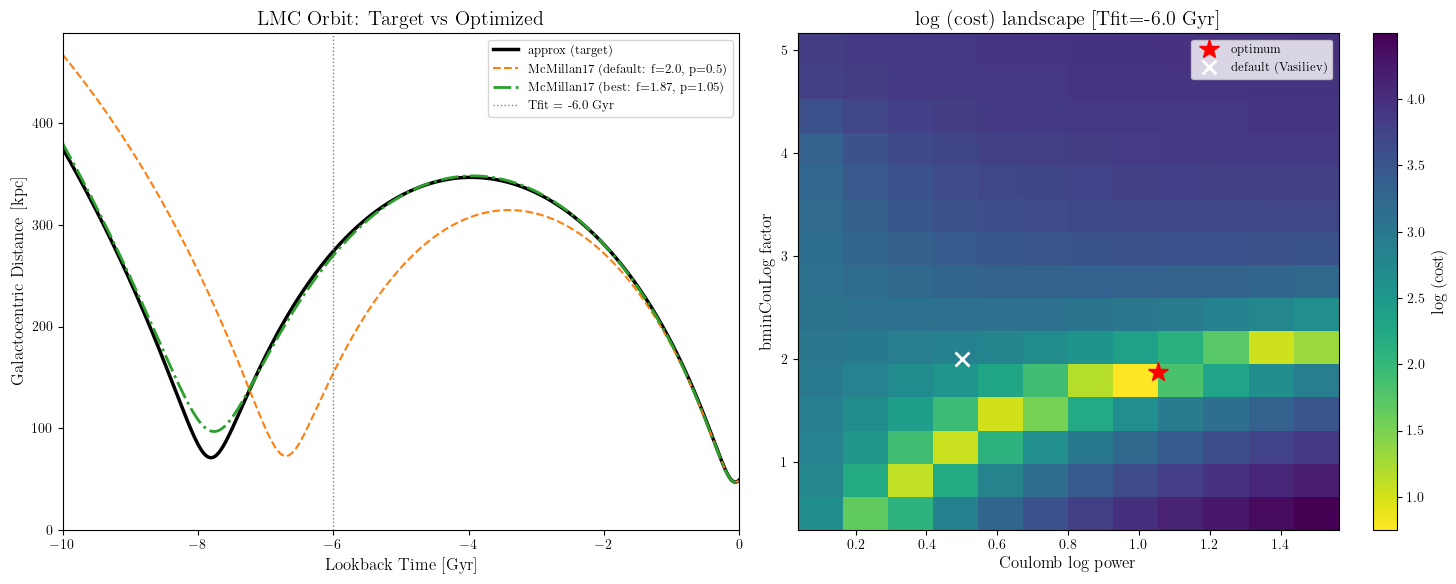

In [10]:
# ============================================================
# 7. PLOTS
# ============================================================
cost_final, t_final, dist_final, dist_ref_final = objective([f_best, p_best], return_full=True)
_, t_default, dist_default, _ = objective([2.0, 0.5], return_full=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Left panel: trajectory comparison ---
ax = axes[0]
ax.plot(t_approx, dist_approx, 'k-', lw=2.5, label='approx (target)', zorder=0)
ax.plot(t_default, dist_default, '--', color='C1', lw=1.5,
        label=f'McMillan17 (default: f=2.0, p=0.5)')
ax.plot(t_final, dist_final, '-.', color='C2', lw=2,
        label=f'McMillan17 (best: f={f_best:.2f}, p={p_best:.2f})')
ax.axvline(Tfit, color='grey', ls=':', lw=1, label=f'Tfit = {Tfit} Gyr')
ax.set_xlabel('Lookback Time [Gyr]')
ax.set_ylabel('Galactocentric Distance [kpc]')
ax.set_title('LMC Orbit: Target vs Optimized')
ax.legend(fontsize=9)
ax.set_xlim(Trewind, 0)
ax.set_ylim(0, None)

# --- Right panel: cost landscape from grid search ---
ax2 = axes[1]
# Clip extreme costs for better visualization
grid_plot = np.log10(np.clip(grid_costs, 1, None))
im = ax2.pcolormesh(powers, factors, grid_plot, shading='auto', cmap='viridis_r')
ax2.plot(p_best, f_best, 'r*', ms=15, label='optimum')
ax2.plot(0.5, 2.0, 'wx', ms=10, mew=2, label='default (Vasiliev)')
ax2.set_xlabel('Coulomb log power')
ax2.set_ylabel('bminCouLog factor')
ax2.set_title(f'log (cost) landscape  [Tfit={Tfit} Gyr]')
plt.colorbar(im, ax=ax2, label='log (cost)')
ax2.legend(fontsize=9)

plt.tight_layout()
# plt.savefig('coulomb_optimization.png', dpi=150, bbox_inches='tight')
# print(f"Plots saved to coulomb_optimization.png")

# ============================================================
# 8. PRINT SUMMARY FOR COPY-PASTE
# ============================================================
print("=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(f"  bminCouLog_factor = {f_best:.4f}")
print(f"  power             = {p_best:.4f}")
print(f"  bminCouLog        = radiusLMC * {f_best:.4f} = {radiusLMC * f_best:.4f} kpc")
print(f"  Fitting window    = [{Tfit}, {Tcurr}] Gyr")
print(f"  Weighted MSE      = {cost_final:.4f} kpc²")
print(f"  Weighted RMSE     = {np.sqrt(cost_final):.4f} kpc")
print("=" * 60)

This looks like a good enough fit